<h1>Morage Default Probability</h1>

### By: Huan Shuo Hsu

## Method Overview
This notebook develops baseline Probability of Default (PD) models using a structured pipeline of data cleaning, feature engineering, and supervised learning. The goal is to understand how borrower and loan characteristics relate to default risk and to evaluate the performance of two foundational classification models.

We apply:

- Data Cleaning & Feature Engineering to standardize missing values, bin skewed continuous variables, and prepare categorical features

- Target Encoding to convert categorical variables into smoothed, information-rich numerical representations

- Decision Tree & Logistic Regression models to estimate the probability of loan default

- Evaluation Metrics including accuracy, confusion matrices, ROC/AUC, precision–recall curves, gains tables, and KS statistics

- Interpretation of Results to compare the models’ ability to separate high-risk and low-risk borrowers


## Table of Contents
* [Section 1: Data Preparation](#1)
    * [1.1 Defining Features and Target](#11)
    * [1.2 Checking Class Balance](#12)
    * [1.3 Train-Test Split](#13)
    * [1.4 Missing Values Check](#14)
* [Section 2: EDA](#2)
    * [2.1 Helper Functions](#21)
    * [2.2 Precent of Total Record & Average Default Rate per Bin](#22)
* [Section 3: Data Cleaning & Feature Engineering](#3)
    * [3.1 Categorical Variables](#31)
    * [3.2 Continuous Variables](#32)
    * [3.3 Finalizing Features](#33)
* [Section 4: Target Encoding](#4)
    * [4.1 Defining TargetEncoder Class](#41)
    * [4.2 Applying Target Encoding](#42)
* [Section 5: Modeling](#5)
    * [5.1 Decision Tree Classifier](#51)
    * [5.2 Logistic Regression Classifier](#52)
* [Section 6: Evalutation](#6)
    * [6.1 Accuracy & Confusion Matrix](#61)
    * [6.2 ROC/AUC](#62)
    * [6.3 Precision–Recall Curve](#63)
    * [6.4 Gains Table](#64)
    * [6.5 KS Statistic](#65)
    * [6.6 Final Summary](#66)
* [Section 7: Profit and Loss Simulations](#7)    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Data Preperation <a name="1"></a>

In [2]:
loan_df = pd.read_csv("data/XYZloan_default.csv")

loan_df.head()


,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,31,2,1,12,7/6/2017 10:21,ios,3,3,1,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,0,27,1,1,12,4/6/2017 12:51,h5,5,4,0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,0,33,1,4,12,7/1/2017 14:11,h5,4,2,0,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,0,34,2,4,12,7/7/2017 10:10,android,5,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,0,47,2,1,12,7/6/2017 14:37,h5,4,4,1,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


## Defining Features and Target <a name="12"></a>

We separate categorical and continuous because:

`contegorical_cols` will ev1entually be used in target encoding

`continuous_cols` may need binning / handling outliers

Having `filtered_cols` in one list makes it easy to subset X

In [3]:
# 15 explanatory variables we aim to use for prediction
filtered_cols = [
    'AP001', 'AP003', 'AP008',
    'CR009', 'CR015', 'CR019',
    'PA022', 'PA023', 'PA029',
    'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014'
]

# Categorical vs continuous features
categorical_cols = [
    'AP001', 'AP003', 'AP008',
    'CR015', 'CR019',
    'PA022', 'PA023',
    'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014'
]

continuous_cols = ['CR009', 'PA029']

# Target variable
target_col = 'loan_default'


## Checking Class Balance (Default Rate) <a name="13"></a>

This matters for train/test splitting and evaluation:

If the classes are imbalanced, we don’t want a split where the test set accidentally has a very different default rate.

In [4]:
loan_default_rate = loan_df[target_col].mean()
n_rows = len(loan_df)

print(f"Rows in dataset: {n_rows}")
print(f"Default rate: {loan_default_rate:.4f} ({loan_default_rate*100:.2f}%)")
loan_df[target_col].value_counts()


Rows in dataset: 80000
Default rate: 0.1936 (19.36%)


loan_default
0    64512
1    15488
Name: count, dtype: int64

### Observations:

- The dataset is imbalanced with a default rate of approximately 20.1%.

- A model could predict “no default” for every loan and still achieve ~80% accuracy. The accuracy can be misleading. Therefore, metrics like precision, recall, F1, ROC-AUC will be more meaningful

- Because the minority class is only 19%, a normal random train/test split may distort the class proportions. We need to stratify when splitting to preserve the real-world class distribution.

## Train/Test Split <a name="14"></a>

`X` = explanatory variables

`y` = what we are predicting (loan_default)

`test_size=0.3` - common choice, leaves enough data for both training and evaluation.

`random_state=0` -  makes the split reproducible.

`stratify=y` - ensures class balance is preserved:

If `19.4%` defaults in full data, we want `≈19.4%` in both train and test.

In [5]:
# Features (15 total)
X = loan_df[filtered_cols].copy()

# Target (Loan default or not)
y = loan_df[target_col].copy()


X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    y,
    test_size=0.3,          # 70% train, 30% test
    random_state=0,
    stratify=y              # keeping default rate similar in train & test
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nDefault rate in FULL data:", y.mean())
print("Default rate in TRAIN:", Y_train.mean())
print("Default rate in TEST:", Y_test.mean())




Train shape: (56000, 15)
Test shape: (24000, 15)

Default rate in FULL data: 0.1936
Default rate in TRAIN: 0.19360714285714287
Default rate in TEST: 0.19358333333333333


## Missing Values Check <a name="15"></a>

Checking where the missing values are helps decide how to handle them later.

In [6]:
X_train.isna().sum()

AP001      0
AP003      0
AP008      0
CR009      0
CR015      0
CR019      0
PA022    270
PA023    270
PA029    270
TD001      0
TD005      0
TD006      0
TD009      0
TD010      0
TD014      0
dtype: int64

`PA022`, `PA023`, `PA029` are the ones with missing values.

# EDA <a name="2"></a>

- Understand variable distributions & relationship with `loan_default`

- Build a generalized version of `make_mean_counts`

- Plot `% of records per bin` and `average default rate per bin` for each variable.


## Helper Function <a name="21"></a>

In [7]:
def make_mean_counts(X_temp, y, col_str):
    """
    Computes:
      - count of each category/bin
      - percent of total records
      - default rate (mean of y)
      
    Works for both categorical and binned continuous variables.
    """
    X = X_temp.copy()
    X['target'] = y
    
    z = (
        X.groupby(col_str)['target']
          .agg(['count', 'mean'])
          .reset_index()
          .sort_values(col_str)
    )
    
    z['count_pct'] = z['count'] / z['count'].sum()
    
    return z


def plot_variable_relationship(X_train, Y_train, col):
    """
    For a given column:
    - Computes count % per category/bin
    - Computes average default rate
    - Creates a 2-panel plot:
        Left  = count %
        Right = default rate
    """
    z = make_mean_counts(X_train, Y_train, col)
    
    x = z[col].astype(str).tolist()
    count_pct = z['count_pct'].values
    y_mean = z['mean'].values
    
    ind = np.arange(len(x))
    width = 0.6
    
    fig = plt.figure(figsize=(16, 4))
    
    # Count Percentage
    plt.subplot(1, 2, 1)
    plt.bar(ind, count_pct, width)
    plt.xticks(ind, x, rotation=45)
    plt.title(f'{col}: Percent of Total Records')
    
    # Default Rate
    plt.subplot(1, 2, 2)
    plt.plot(ind, y_mean, marker='o')
    plt.xticks(ind, x, rotation=45)
    plt.title(f'{col}: Average Default Rate')
    
    plt.tight_layout()
    plt.show()

    return z

## Precent of Total Record & Average Default Rate per Bin <a name="22"></a>

We plot the `categorical_col` to see `% of records per bin` and `average default rate per bin` side-by-side.


============ AP001 ============


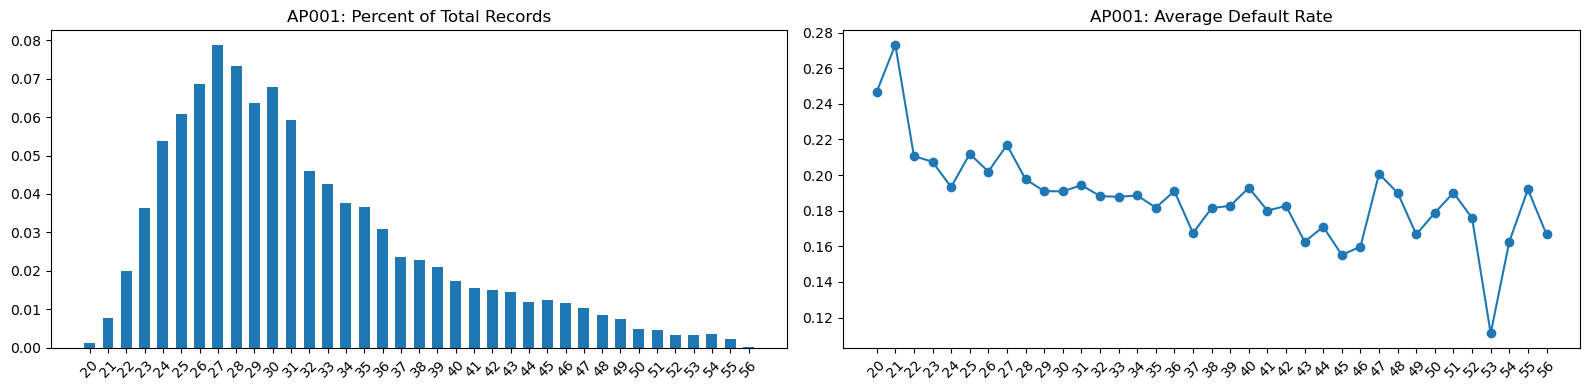

,AP001,count,mean,count_pct
0,20,77,0.246753,0.001375
1,21,432,0.273148,0.007714
2,22,1125,0.210667,0.020089
3,23,2034,0.207473,0.036321
4,24,3012,0.193227,0.053786



============ AP003 ============


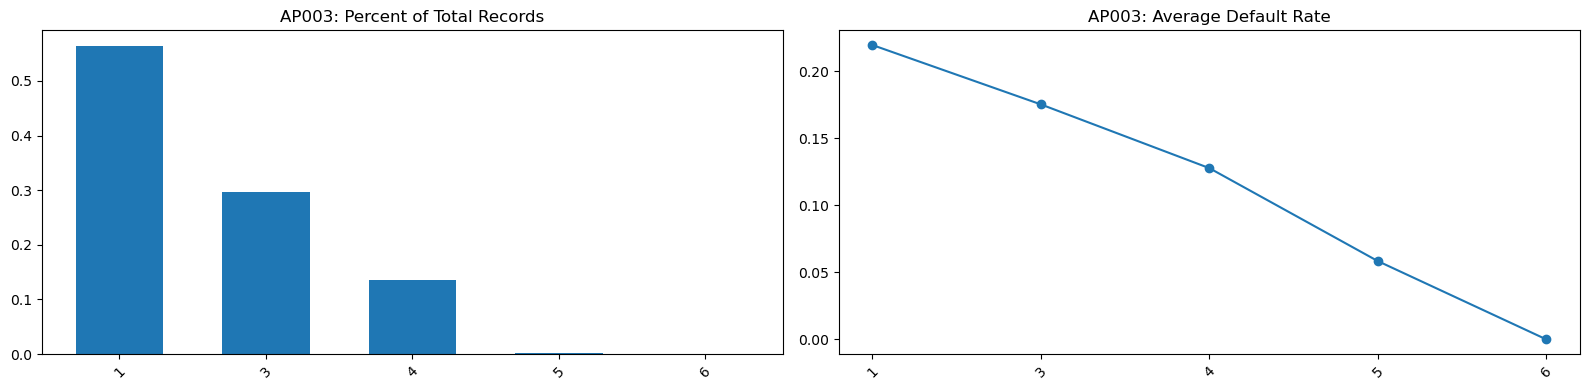

,AP003,count,mean,count_pct
0,1,31605,0.219744,0.564375
1,3,16612,0.175415,0.296643
2,4,7619,0.127838,0.136054
3,5,154,0.058442,0.002750
4,6,10,0.000000,0.000179



============ AP008 ============


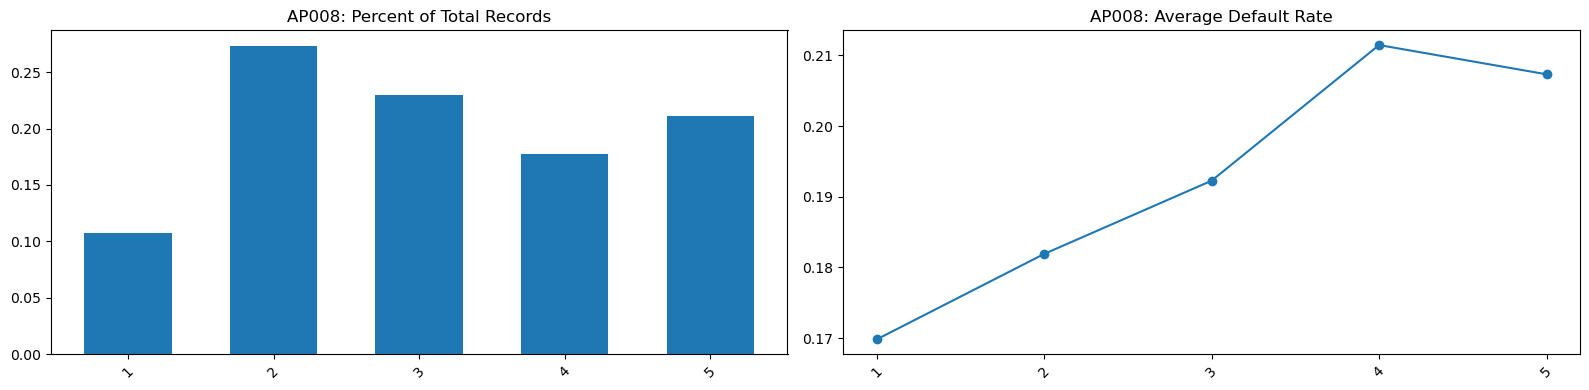

,AP008,count,mean,count_pct
0,1,6030,0.169818,0.107679
1,2,15310,0.181907,0.273393
2,3,12878,0.192266,0.229964
3,4,9950,0.211457,0.177679
4,5,11832,0.207319,0.211286



============ CR015 ============


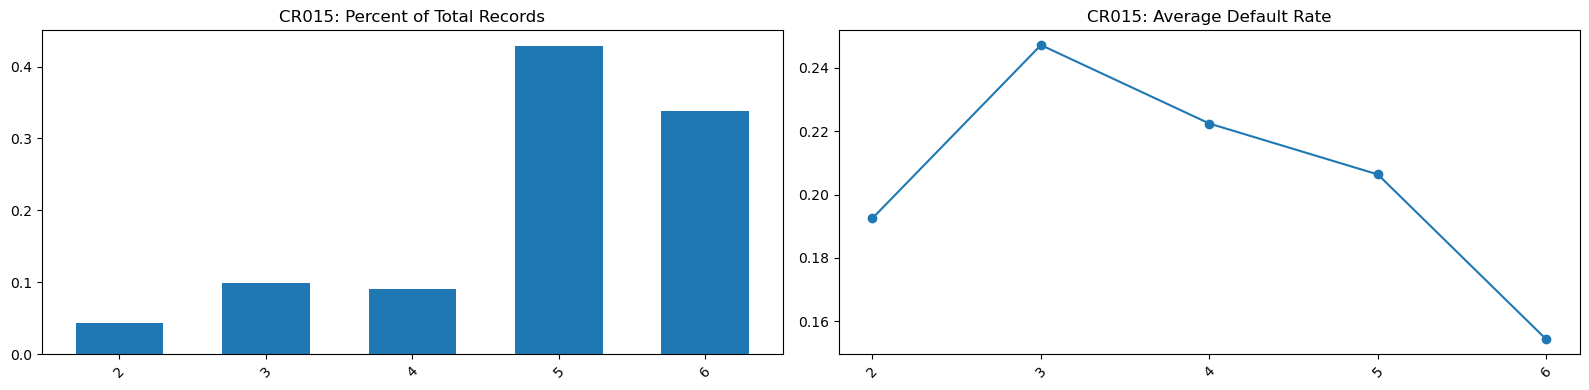

,CR015,count,mean,count_pct
0,2,2415,0.192547,0.043125
1,3,5526,0.247195,0.098679
2,4,5058,0.222420,0.090321
3,5,24026,0.206360,0.429036
4,6,18975,0.154308,0.338839



============ CR019 ============


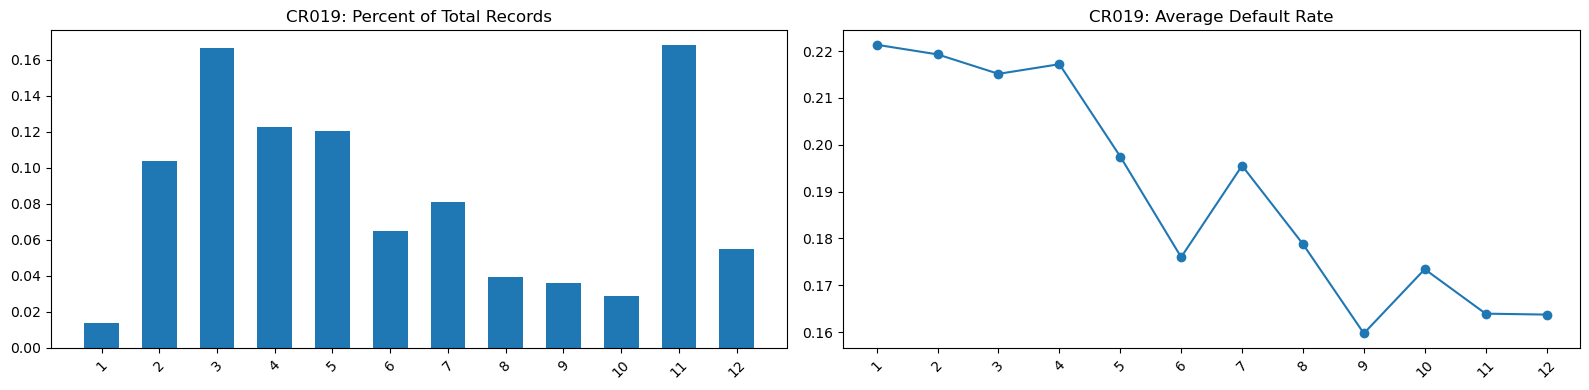

,CR019,count,mean,count_pct
0,1,768,0.221354,0.013714
1,2,5814,0.219298,0.103821
2,3,9324,0.215144,0.166500
3,4,6869,0.217208,0.122661
4,5,6750,0.197481,0.120536



============ PA022 ============


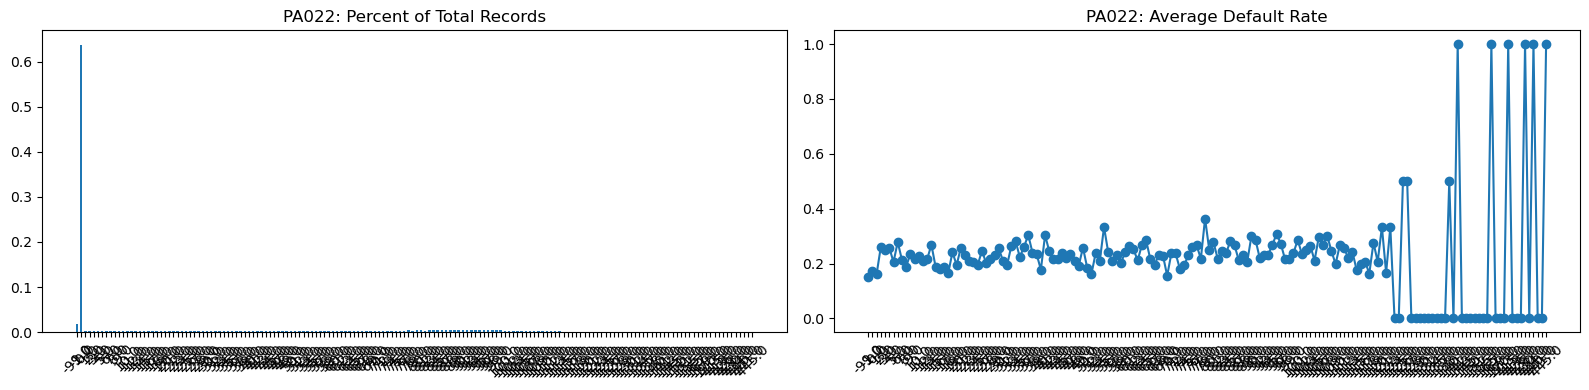

,PA022,count,mean,count_pct
0,-99.0,1069,0.151543,0.019182
1,-1.0,35530,0.171461,0.637538
2,0.0,92,0.163043,0.001651
3,1.0,149,0.261745,0.002674
4,2.0,148,0.250000,0.002656



============ PA023 ============


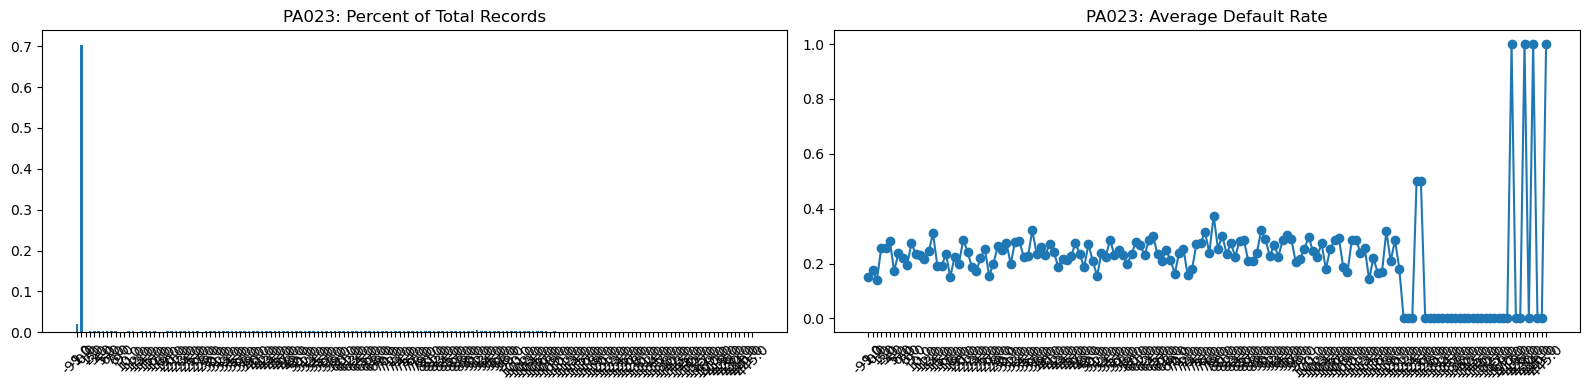

,PA023,count,mean,count_pct
0,-99.0,1069,0.151543,0.019182
1,-1.0,39228,0.175385,0.703894
2,0.0,79,0.139241,0.001418
3,1.0,129,0.255814,0.002315
4,2.0,120,0.258333,0.002153



============ TD001 ============


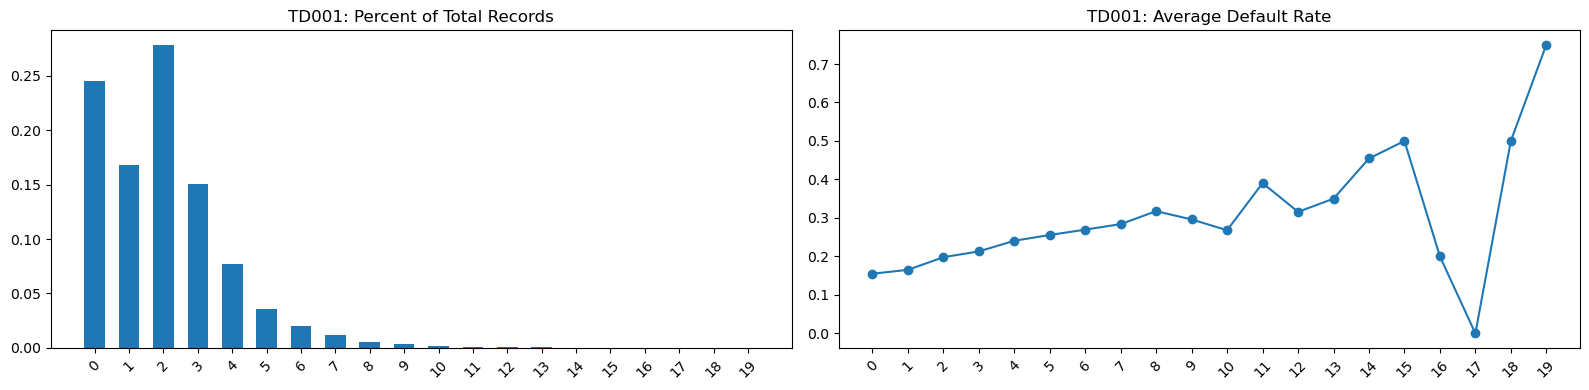

,TD001,count,mean,count_pct
0,0,13749,0.155066,0.245518
1,1,9395,0.165194,0.167768
2,2,15565,0.197944,0.277946
3,3,8451,0.213111,0.150911
4,4,4316,0.240732,0.077071



============ TD005 ============


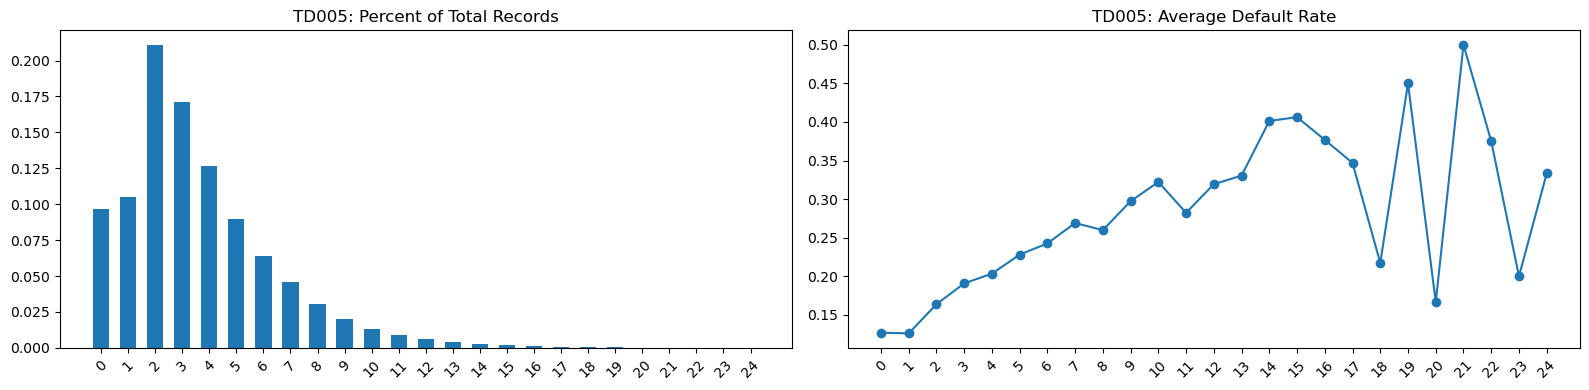

,TD005,count,mean,count_pct
0,0,5421,0.127098,0.096804
1,1,5876,0.126106,0.104929
2,2,11790,0.163783,0.210536
3,3,9602,0.190898,0.171464
4,4,7103,0.203435,0.126839



============ TD006 ============


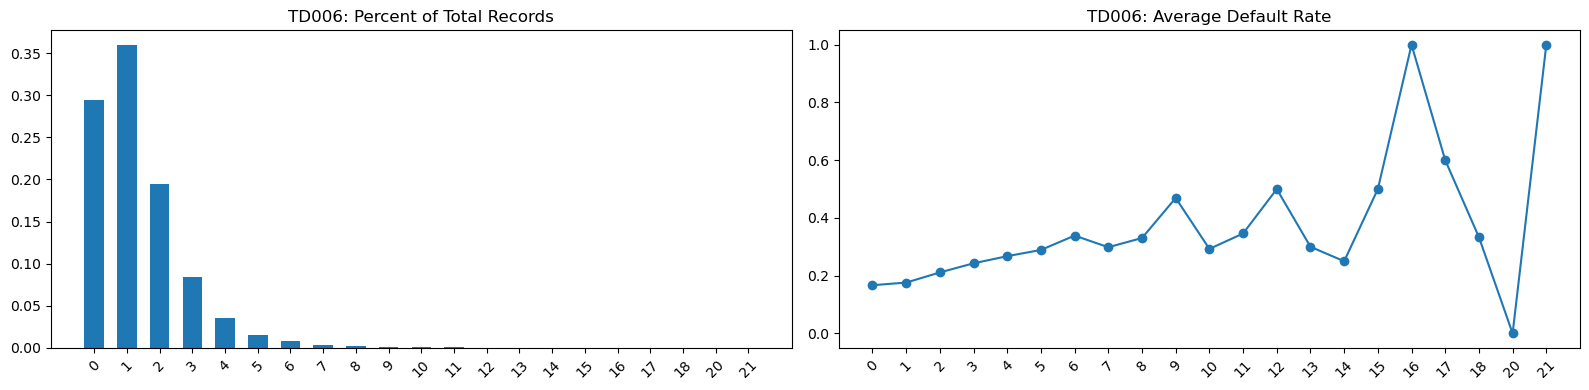

,TD006,count,mean,count_pct
0,0,16481,0.166980,0.294304
1,1,20116,0.176029,0.359214
2,2,10899,0.211212,0.194625
3,3,4715,0.242842,0.084196
4,4,1981,0.267542,0.035375



============ TD009 ============


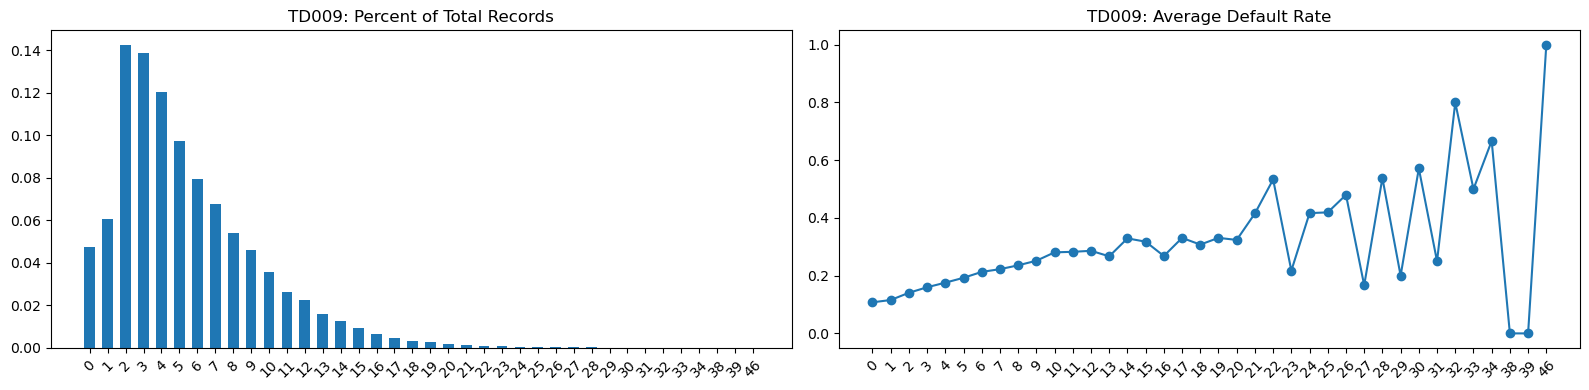

,TD009,count,mean,count_pct
0,0,2646,0.107710,0.047250
1,1,3406,0.115678,0.060821
2,2,7969,0.140670,0.142304
3,3,7768,0.159887,0.138714
4,4,6730,0.175780,0.120179



============ TD010 ============


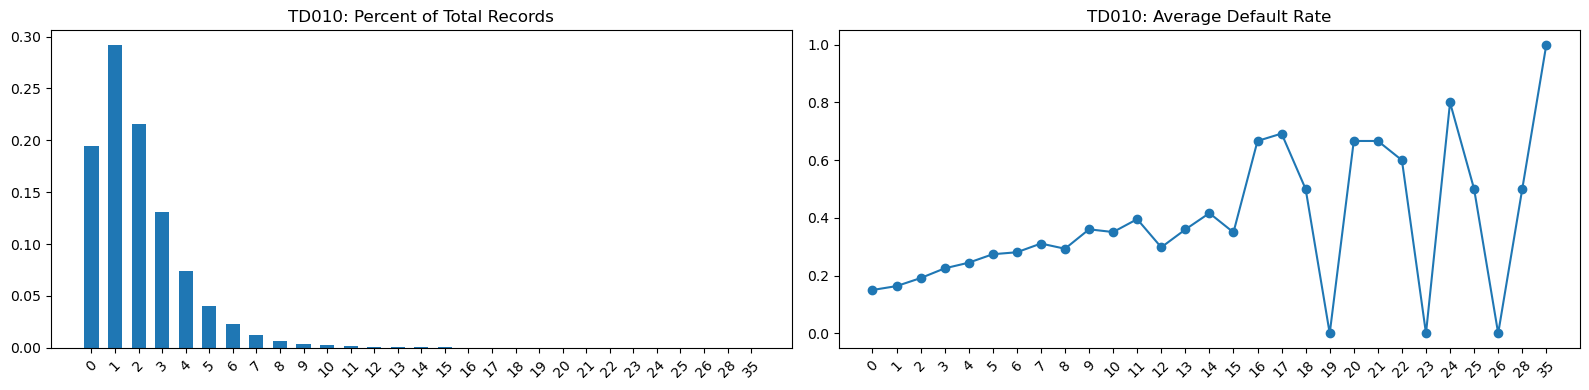

,TD010,count,mean,count_pct
0,0,10893,0.150372,0.194518
1,1,16318,0.163868,0.291393
2,2,12082,0.191607,0.215750
3,3,7335,0.225358,0.130982
4,4,4122,0.245027,0.073607



============ TD014 ============


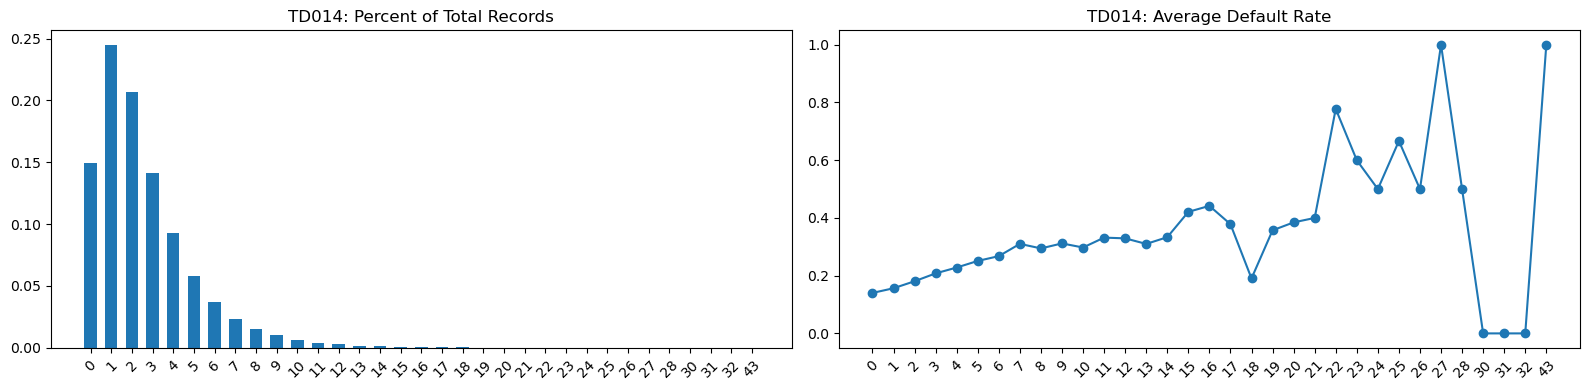

,TD014,count,mean,count_pct
0,0,8386,0.140234,0.149750
1,1,13686,0.156437,0.244393
2,2,11566,0.180702,0.206536
3,3,7919,0.207981,0.141411
4,4,5210,0.228215,0.093036


In [8]:
for col in categorical_cols:
    print(f"\n============ {col} ============")
    z = plot_variable_relationship(X_train, Y_train, col)
    display(z.head())

# Data Cleaning & Feature Engineering <a name="3"></a>

In this section, we will handle:

- Missing values

- Special missing codes (-99, -98, -1)

- Binning continuous variables (CR009, PA029)

- Preparing categorical variables for target encoding

- Creating cleaned X_train and X_test ready for modeling

## Categorical Variables <a name="31"></a>

- `PA022`, `PA023` have several -99, -1, -98, NAs. These represent missing values and need to be imputed or put in separate bins.

- For categorical features, we do NOT want mean imputation because:

    - It destroys the meaning of categories

    - We will apply target encoding later, so categories must stay intact


- We will convert -99, -98, -1, NaN into `Missing` (a new category)

    - This preserves information about whether the value was missing.

    - Target encoding later will assign a default rate to `Missing` itself.

In [9]:
def clean_categorical_missing(X, categorical_cols):
    X_clean = X.copy()
    
    missing_codes = [-99, -98, -1]
    
    for col in categorical_cols:
        X_clean[col] = X_clean[col].replace(missing_codes, np.nan)
        X_clean[col] = X_clean[col].fillna("Missing").astype(str)
    
    return X_clean

X_train_cat = clean_categorical_missing(X_train, categorical_cols)
X_test_cat  = clean_categorical_missing(X_test, categorical_cols)



## Continuous Variables <a name="32"></a>

`PA029` has special missing codes (-99, -98) and NAs. We will:

- Remove the special codes before finding bins

- Compute quantile-based bins (qcut)

- Replace the largest cutpoint with the 95th percentile

- Clean up bins

- Apply bins to FULL training column

- Apply Binning to Test Set


`PA009` has no missing values so we can directly compute quantile-based bins (qcut) and apply to both train and test sets.

In [10]:
# Removing special missing codes from PA029

pa029_clean = X_train['PA029'].copy()

# Define missing codes
missing_codes = [-99, -98]

# Mask out valid numeric values for binning
valid_pa029 = pa029_clean[~pa029_clean.isin(missing_codes)]


In [11]:
# Compute quantile-based bins (qcut)

series, bins = pd.qcut(valid_pa029, q=10, duplicates='drop', retbins=True)

bins


array([   0. ,   17. ,   26. ,   34. ,   43.5,   54. ,   66. ,   83. ,
        110. ,  167. , 2872. ])

In [12]:
# Replace the largest cutpoint with the 95th percentile
# This protects against unseen huge values in test set.

p95 = np.percentile(valid_pa029, 95)
bins[-1] = p95

bins


array([  0. ,  17. ,  26. ,  34. ,  43.5,  54. ,  66. ,  83. , 110. ,
       167. ,   nan])

In [13]:
# Cleaning up bins

# Remove NaN if any
bins = bins[~np.isnan(bins)]

# Remove duplicates (can happen after replacing last bin)
bins = np.unique(bins)

# Ensure they are strictly increasing
bins = np.sort(bins)

bins


array([  0. ,  17. ,  26. ,  34. ,  43.5,  54. ,  66. ,  83. , 110. ,
       167. ])

In [14]:
# Apply bins to FULL training column (PA029)

X_train['PA029_NEW'] = pd.cut(X_train['PA029'], bins=bins, include_lowest=True)

X_train['PA029_NEW'] = X_train['PA029_NEW'].cat.add_categories(['Missing', '-98', '-99'])

# Fill missing and special codes
X_train.loc[X_train['PA029'].isna(), 'PA029_NEW'] = 'Missing'
X_train.loc[X_train['PA029'] == -98, 'PA029_NEW'] = '-98'
X_train.loc[X_train['PA029'] == -99, 'PA029_NEW'] = '-99'

# Convert to string for consistency
X_train['PA029_NEW'] = X_train['PA029_NEW'].astype(str)


In [15]:
# Apply Binning to Test Set (PA029)

X_test['PA029_NEW'] = pd.cut(X_test['PA029'], bins=bins, include_lowest=True)

# Add special categories
X_test['PA029_NEW'] = X_test['PA029_NEW'].cat.add_categories(['Missing', '-98', '-99'])

X_test.loc[X_test['PA029'].isna(), 'PA029_NEW'] = 'Missing'
X_test.loc[X_test['PA029'] == -98, 'PA029_NEW'] = '-98'
X_test.loc[X_test['PA029'] == -99, 'PA029_NEW'] = '-99'

X_test['PA029_NEW'] = X_test['PA029_NEW'].astype(str)


In [16]:
# Compute bins from TRAIN ONLY (CR009)
cr009_series, cr009_bins = pd.qcut(X_train['CR009'], q=10, duplicates='drop', retbins=True)

# Extend last bin to infinity
cr009_bins[-1] = np.percentile(X_train['CR009'], 95)
cr009_bins = np.append(cr009_bins, np.inf)

X_train['CR009_NEW'] = pd.cut(X_train['CR009'], bins=cr009_bins, include_lowest=True).astype(str)
X_test['CR009_NEW']  = pd.cut(X_test['CR009'],  cr009_bins, include_lowest=True).astype(str)



## Finalizing Features<a name="33"></a>

We will now combine the processed categoriacal features with our binned continuous features to create the final feature set for modeling.

We should see:

- No raw continuous variables

- New binned versions

- All missing categorical values replaced with "Missing"

In [17]:
final_categorical_cols = categorical_cols + ['PA029_NEW', 'CR009_NEW']

X_train_clean = X_train_cat.copy()
X_test_clean  = X_test_cat.copy()

# Add binned versions
X_train_clean['PA029_NEW'] = X_train['PA029_NEW']
X_train_clean['CR009_NEW'] = X_train['CR009_NEW']

X_test_clean['PA029_NEW'] = X_test['PA029_NEW']
X_test_clean['CR009_NEW'] = X_test['CR009_NEW']

# Drop the raw continuous columns
X_train_clean = X_train_clean.drop(columns=['PA029', 'CR009'])
X_test_clean  = X_test_clean.drop(columns=['PA029', 'CR009'])

X_train_clean.head()




,AP001,AP003,AP008,CR015,CR019,PA022,PA023,TD001,TD005,TD006,TD009,TD010,TD014,PA029_NEW,CR009_NEW
3172,25,1,3,5,12,Missing,Missing,0,2,0,5,1,2,-98,"(6700.0, 11457.0]"
27043,36,4,3,6,12,Missing,Missing,3,7,2,7,2,3,-98,"(123984.8, inf]"
37778,46,1,3,6,11,78.0,78.0,2,2,0,2,0,0,"(43.5, 54.0]","(-0.001, 2498.0]"
39745,30,3,3,5,5,Missing,Missing,4,8,2,12,3,3,-98,"(50000.0, 83000.0]"
22965,35,1,1,5,8,34.0,34.0,0,1,1,2,2,2,"(43.5, 54.0]","(24300.0, 34000.0]"


# Target Encoding <a name="4"></a>


Target encoding replaces each category in a variable with the smoothed average default rate for that category:

- It reduces dimensionality
    - Instead of creating many dummy variables (one per category), each categorical feature becomes a single numeric column.

- It incorporates target information
    - Categories with higher default rates get higher encoded values, helping models such as logistic regression and decision trees capture meaningful patterns.

- Smoothing prevents overfitting
    - Rare categories shrink toward the global mean default rate, avoiding extreme or noisy estimates.

    
In this section, we will:

- Define the encoder class

- Fit on X_train_clean + Y_train

- Transform both X_train_clean and X_test_clean

- Verify results

- Explain the rationale

## Defining TargetEncoder Class <a name="41"></a>

In [18]:
class TargetEncoder:
    def __init__(self, cat_cols=None, smoothing=20.0, min_samples_leaf=1):
        """
        Parameters
        ----------
        cat_cols : list[str] or None
            Categorical columns to encode. If None, infers object/category cols.
        smoothing : float
            Strength of smoothing toward the global mean.
            Larger = more shrinkage for small-count categories.
        min_samples_leaf : int
            Minimum category count before relying less on smoothing.
        """
        self.cat_cols = cat_cols
        self.smoothing = float(smoothing)
        self.min_samples_leaf = int(min_samples_leaf)
        self.mappings_ = {}        # {col: {category: smoothed_mean}}
        self.global_mean_ = None   # float
        self.fitted_cat_cols_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # Learn target-mean mappings from TRAIN ONLY.

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y = pd.Series(y)

        # Global mean of the target
        self.global_mean_ = y.mean()

        # Determine categorical columns
        if self.cat_cols is None:
            self.fitted_cat_cols_ = [
                c for c in X.columns if X[c].dtype == "object" or pd.api.types.is_categorical_dtype(X[c])
            ]
        else:
            self.fitted_cat_cols_ = list(self.cat_cols)

        # Build mappings per column with smoothing
        for col in self.fitted_cat_cols_:
            # groupby stats on TRAIN
            stats = (
                pd.DataFrame({"cat": X[col], "y": y})
                .groupby("cat")["y"]
                .agg(["count", "mean"])
            )

            # smoothing factor per category
            counts = stats["count"].clip(lower=self.min_samples_leaf)
            weights = counts / (counts + self.smoothing)

            # smoothed mean = weight * cat_mean + (1 - weight) * global_mean
            smoothed = weights * stats["mean"] + (1.0 - weights) * self.global_mean_

            self.mappings_[col] = smoothed.to_dict()

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Apply learned mappings to any data (train or test).
        Unseen categories map to the global mean from train (no leakage).
        """
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if self.global_mean_ is None or self.mappings_ is None:
            raise RuntimeError("TargetEncoder must be fit before transform().")

        X_enc = X.copy()

        for col in self.fitted_cat_cols_:
            mapping = self.mappings_[col]
            X_enc[col] = X_enc[col].map(mapping).astype(float)
            X_enc[col] = X_enc[col].fillna(self.global_mean_)   # unseen categories get global mean

        return X_enc

    def fit_transform(self, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
        return self.fit(X, y).transform(X)


## Applying Target Encoding <a name="42"></a>

In [19]:
final_categorical_cols = categorical_cols + ['PA029_NEW', 'CR009_NEW']

# Fit on training data
encoder = TargetEncoder(
    cat_cols=final_categorical_cols,
    smoothing=20.0,
    min_samples_leaf=1
)

X_train_enc = encoder.fit_transform(X_train_clean, Y_train)

# Transform test data
X_test_enc = encoder.transform(X_test_clean)

# Verify
X_train_enc.head()


,AP001,AP003,AP008,CR015,CR019,PA022,PA023,TD001,TD005,TD006,TD009,TD010,TD014,PA029_NEW,CR009_NEW
3172,0.211782,0.219727,0.192268,0.206349,0.163930,0.171159,0.174979,0.155122,0.163833,0.167012,0.192642,0.163905,0.180724,0.174085,0.206615
27043,0.191002,0.128010,0.192268,0.154350,0.163930,0.171159,0.174979,0.213065,0.268508,0.211180,0.222364,0.191611,0.207945,0.174085,0.152792
37778,0.160816,0.219727,0.192268,0.154350,0.164003,0.348992,0.354493,0.197939,0.163833,0.167012,0.140803,0.150451,0.140361,0.252232,0.179542
39745,0.190854,0.175437,0.192268,0.206349,0.197470,0.171159,0.174979,0.240515,0.259099,0.211180,0.284715,0.225272,0.207945,0.174085,0.174516
22965,0.181844,0.219727,0.169896,0.206349,0.178932,0.219808,0.220263,0.155122,0.126335,0.176046,0.140803,0.191611,0.180724,0.252232,0.207338


### Final Check

We do a final check to ensure all datatype are numeric and there are no missing values.

In [20]:
X_train_final = X_train_enc.copy()
X_test_final  = X_test_enc.copy()

X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, 3172 to 14753
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AP001      56000 non-null  float64
 1   AP003      56000 non-null  float64
 2   AP008      56000 non-null  float64
 3   CR015      56000 non-null  float64
 4   CR019      56000 non-null  float64
 5   PA022      56000 non-null  float64
 6   PA023      56000 non-null  float64
 7   TD001      56000 non-null  float64
 8   TD005      56000 non-null  float64
 9   TD006      56000 non-null  float64
 10  TD009      56000 non-null  float64
 11  TD010      56000 non-null  float64
 12  TD014      56000 non-null  float64
 13  PA029_NEW  56000 non-null  float64
 14  CR009_NEW  56000 non-null  float64
dtypes: float64(15)
memory usage: 6.8 MB


# Modeling <a name="5"></a>

In this section, we will:
- Build a decision tree model using your cleaned features to predict loan_default.

- Build a logistic regression using your cleaned features to predict loan_default.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Decision Tree Classifier<a name="51"></a>

In [22]:
dt_model = DecisionTreeClassifier(
    max_depth=5,            # prevents overfitting
    min_samples_leaf=50,    # stabilizes splits
    random_state=0
)

dt_model.fit(X_train_final, Y_train)

# Predictions
dt_pred_class = dt_model.predict(X_test_final)
dt_pred_prob  = dt_model.predict_proba(X_test_final)[:, 1]


## Logistic Regression Classifier<a name="52"></a>

In [23]:
log_model = LogisticRegression(
    max_iter=500,
    solver='liblinear'
)

log_model.fit(X_train_final, Y_train)

# Predictions
log_pred_class = log_model.predict(X_test_final)
log_pred_prob  = log_model.predict_proba(X_test_final)[:, 1]


# Evaluation <a name="6"></a>

## Accuracy & Confusion Matrix <a name="61"></a>

In [24]:
def print_basic_metrics(y_true, y_pred, model_name):
    print(f"\n===== {model_name} =====")
    
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

print_basic_metrics(Y_test, dt_pred_class, "Decision Tree")
print_basic_metrics(Y_test, log_pred_class, "Logistic Regression")



===== Decision Tree =====
Accuracy: 0.8057
Confusion Matrix:
[[19295    59]
 [ 4604    42]]

===== Logistic Regression =====
Accuracy: 0.8058
Confusion Matrix:
[[19314    40]
 [ 4621    25]]


## ROC Curve & AUC <a name="62"></a>

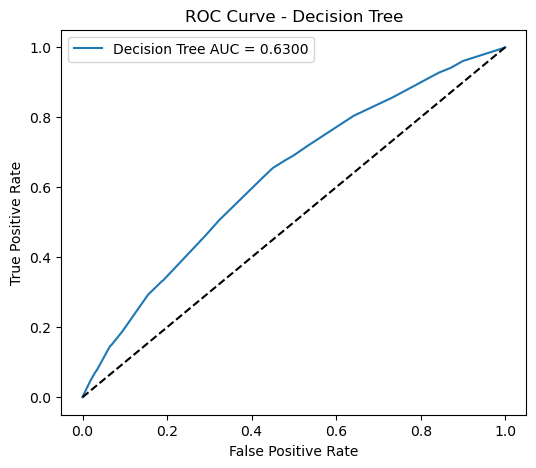

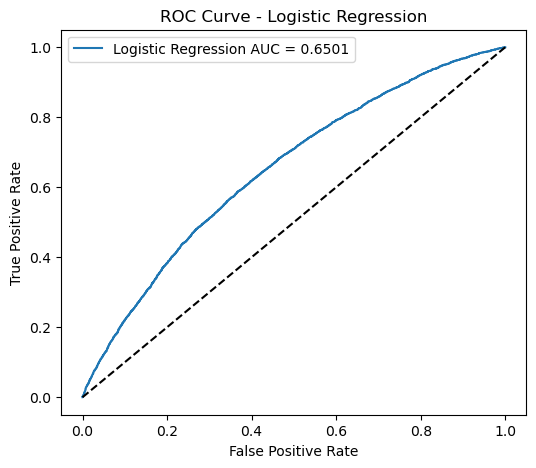

In [25]:
def plot_roc(y_true, y_prob, model_name):
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{model_name} AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()
    
    return auc

dt_auc = plot_roc(Y_test, dt_pred_prob, "Decision Tree")
log_auc = plot_roc(Y_test, log_pred_prob, "Logistic Regression")


## Precision & Recall <a name="63"></a>

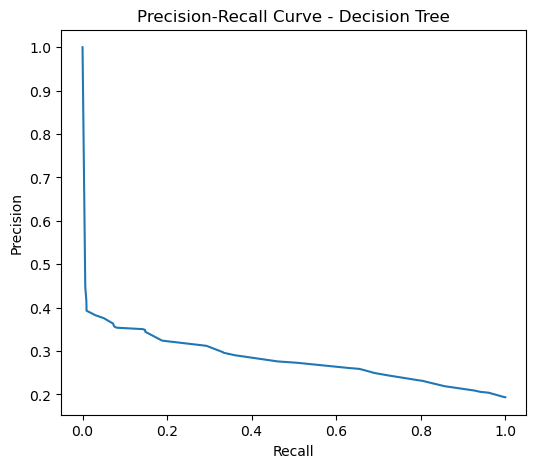

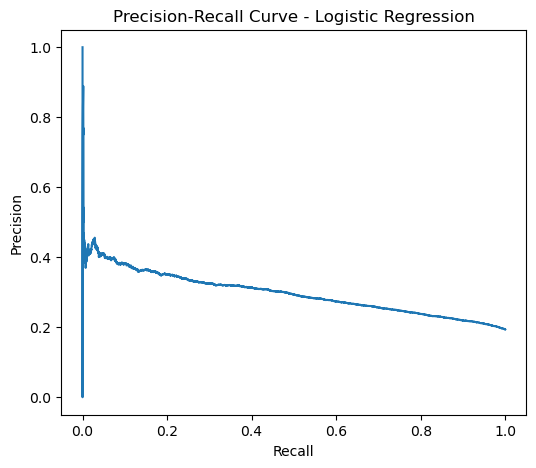

In [26]:
def plot_pr(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.show()

plot_pr(Y_test, dt_pred_prob, "Decision Tree")
plot_pr(Y_test, log_pred_prob, "Logistic Regression")


## Gains Table <a name="64"></a>

In [27]:
def gains_table(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob
    })

    df["bin"] = pd.qcut(df["y_prob"], n_bins, duplicates='drop')

    grouped = df.groupby("bin")["y_true"].agg(["count", "sum"])
    grouped.rename(columns={"sum": "defaults"}, inplace=True)

    grouped["cum_defaults"] = grouped["defaults"].cumsum()
    grouped["cum_pct_defaults"] = grouped["cum_defaults"] / grouped["defaults"].sum()

    return grouped.sort_index(ascending=False)

dt_gains = gains_table(Y_test, dt_pred_prob)
log_gains = gains_table(Y_test, log_pred_prob)

print("\nDecision Tree Gains Table:")
display(dt_gains)

print("\nLogistic Regression Gains Table:")
display(log_gains)



Decision Tree Gains Table:


C:\Users\User\AppData\Local\Temp\ipykernel_21432\3807341284.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin")["y_true"].agg(["count", "sum"])
C:\Users\User\AppData\Local\Temp\ipykernel_21432\3807341284.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin")["y_true"].agg(["count", "sum"])


,count,defaults,cum_defaults,cum_pct_defaults
bin,,,,
"(0.292, 0.587]",2004,690,4646,1.000000
"(0.255, 0.292]",2361,672,3956,0.851485
"(0.23, 0.255]",1405,313,3284,0.706845
"(0.213, 0.23]",2848,678,2971,0.639475
"(0.169, 0.213]",3156,693,2293,0.493543
"(0.149, 0.169]",1904,297,1600,0.344382
"(0.127, 0.149]",2473,393,1303,0.280456
"(0.12, 0.127]",2004,241,910,0.195867
"(0.109, 0.12]",3080,396,669,0.143995



Logistic Regression Gains Table:


,count,defaults,cum_defaults,cum_pct_defaults
bin,,,,
"(0.304, 0.66]",2400,845,4646,1.000000
"(0.253, 0.304]",2400,690,3801,0.818123
"(0.221, 0.253]",2400,640,3111,0.669608
"(0.197, 0.221]",2400,495,2471,0.531855
"(0.177, 0.197]",2400,460,1976,0.425312
"(0.16, 0.177]",2400,406,1516,0.326302
"(0.143, 0.16]",2400,351,1110,0.238915
"(0.127, 0.143]",2400,320,759,0.163366
"(0.105, 0.127]",2400,263,439,0.094490


## KS Statistic <a name="65"></a>

In [28]:
def ks_statistic(y_true, y_prob):
    df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob})
    
    df = df.sort_values("y_prob")
    
    df["cum_good"] = (df["y_true"] == 0).cumsum() / (df["y_true"] == 0).sum()
    df["cum_bad"]  = (df["y_true"] == 1).cumsum() / (df["y_true"] == 1).sum()
    
    ks = max(abs(df["cum_good"] - df["cum_bad"]))
    return ks

dt_ks = ks_statistic(Y_test, dt_pred_prob)
log_ks = ks_statistic(Y_test, log_pred_prob)

print(f"\nDecision Tree KS: {dt_ks:.4f}")
print(f"Logistic Regression KS: {log_ks:.4f}")



Decision Tree KS: 0.2054
Logistic Regression KS: 0.2207


## Final Summary <a name="66"></a>

In [29]:
print("\nSUMMARY\n")

print(f"Decision Tree AUC: {dt_auc:.4f}")
print(f"Decision Tree KS:  {dt_ks:.4f}\n")

print(f"Logistic Regression AUC: {log_auc:.4f}")
print(f"Logistic Regression KS:  {log_ks:.4f}")



SUMMARY

Decision Tree AUC: 0.6300
Decision Tree KS:  0.2054

Logistic Regression AUC: 0.6501
Logistic Regression KS:  0.2207


### Decision Tree Performance Summary

`Confusion Matrix Analysis`
- Correctly identifies most non-defaulting borrowers.

- Detects 42 true defaults, but still misses the majority (4,604 false negatives).

- Has slightly more false positives (59) compared to logistic regression.

- Captures more defaults than logistic regression but still underperforms overall in identifying risky borrowers.


`Accuracy: 80.57%`

- The accuracy is somewhat misleading due to class imbalance.

`AUC = 0.6300`

- This means the model has modest discriminatory power, better than random (0.50), but not strong.

`Precision–Recall Curve`

- Precision declines as recall increases.

- This indicates that high-recall predictions come at the cost of many false positives.

`Gains Table`

- Top decile captures ~6% of defaults.

- Cumulative curve shows slower improvement, reflecting weaker segmentation.

`KS Statistic = 0.2054`

- KS around 0.20 is expected for a simple baseline model.

- This indicates moderate separation between default and non-default distributions.

### Logistic Regression Performance Summary

`Confusion Matrix Analysis`
- Correctly identifies most non-defaulting borrowers with fewer false positives (40).

- Detects fewer true defaults (25 true positives).

- Misses slightly more actual defaulters (4,621 false negatives).

- More precise for non-defaults but weaker at capturing true defaults compared to the decision tree.

`Accuracy: 80.58%`

- The accuracy is somewhat misleading due to class imbalance.

`AUC = 0.6501`

- This performs better than the decision tree.

- It shows smoother ranking capability which is a good sign for credit scoring.

`Precision–Recall Curve`

- Noticeably smoother and more stable.

- At low recall levels, precision is significantly higher than the baseline default rate.

`Gains Table`

- Top decile captures ~18% of defaults.

- Stronger lift compared to the decision tree.

`KS Statistic = 0.2207`

- Slightly higher than the tree.

- This indicates better risk ranking.

Overall, both models achieve similar accuracy, but their true performance differs when evaluating how well they identify defaulting borrowers. The decision tree captures slightly more true defaults but still misses the vast majority, while producing slightly more false positives. The logistic regression model is more conservative, producing fewer false positives, but identifies fewer actual defaults. 

Between the two, `logistic regression` provides better overall risk ranking (higher AUC and KS), but both models have limited ability to detect defaults with the current feature set, highlighting the need for more predictive variables or additional feature engineering.

# Profit and Loss Simulations <a name="7"></a>

Finally, we will conduct a profit and loss simulations at varying interest rates (4%, 8%, 12%) to see how the predicted probabilities of default impact expected profitability.

In [31]:
def simulate_profit_loss(y_prob, interest_rate, loan_amount=100000, LGD=0.6):
    """
    y_prob       : predicted probability of default (PD)
    interest_rate: annual interest rate (0.04, 0.08, 0.12, etc.)
    loan_amount  : assumed loan principal
    LGD          : Loss Given Default (60% assumed here)
    """

    y_prob = np.array(y_prob)

    # Expected revenue from interest
    expected_revenue = loan_amount * interest_rate * (1 - y_prob)

    # Expected loss from default
    expected_loss = loan_amount * LGD * y_prob

    # Net expected value
    net_profit = expected_revenue - expected_loss

    return pd.DataFrame({
        "PD": y_prob,
        "Expected_Revenue": expected_revenue,
        "Expected_Loss": expected_loss,
        "Net_Profit": net_profit
    })


# Run P/L simulation at different interest rates
rates = [0.04, 0.08, 0.12]

results = {}

for r in rates:
    results[f"Rate_{int(r*100)}%"] = simulate_profit_loss(log_pred_prob, r)


# Display summaries
for rate, df_rate in results.items():
    print(f"\n===== Profit/Loss Summary at {rate} =====")
    print(df_rate["Net_Profit"].describe())



===== Profit/Loss Summary at Rate_4% =====
count    24000.000000
mean     -8370.889138
std       5164.972726
min     -38224.247511
25%     -11054.891660
50%      -7350.874514
75%      -4664.351600
max       2003.461851
Name: Net_Profit, dtype: float64

===== Profit/Loss Summary at Rate_8% =====
count    24000.000000
mean     -5144.069709
std       5487.783521
min     -36863.262981
25%      -7995.822389
50%      -4060.304171
75%      -1205.873575
max       5878.678217
Name: Net_Profit, dtype: float64

===== Profit/Loss Summary at Rate_12% =====
count    24000.000000
mean     -1917.250280
std       5810.594317
min     -35502.278450
25%      -4936.753118
50%       -769.733828
75%       2252.604450
max       9753.894583
Name: Net_Profit, dtype: float64


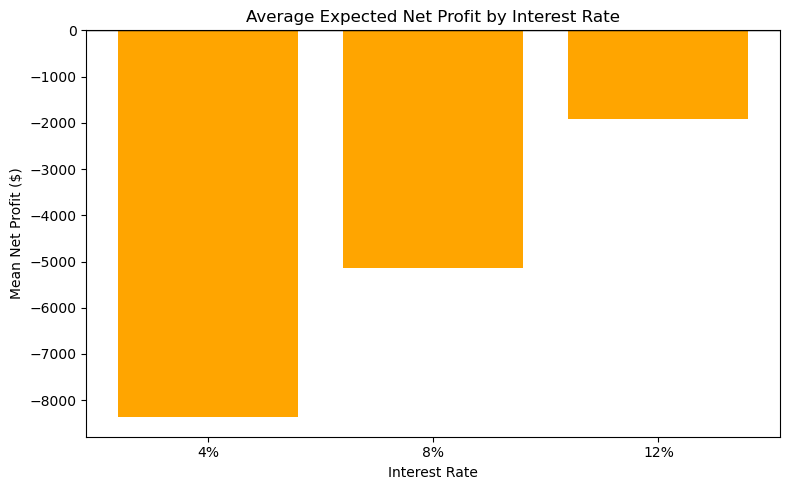

In [ ]:
# Extract rates and mean net profits directly from the results dictionary
rates = []
mean_profits = []

for key, df_rate in results.items():
    rates.append(key.replace("Rate_", ""))          # "Rate_4%" -> "4%"
    mean_profits.append(df_rate["Net_Profit"].mean())

# Plot the bar chart
plt.figure(figsize=(8,5))
plt.bar(rates, mean_profits, color="orange")
plt.axhline(0, color='black', linewidth=1)

plt.title("Average Expected Net Profit by Interest Rate")
plt.xlabel("Interest Rate")
plt.ylabel("Mean Net Profit ($)")
plt.tight_layout()
plt.show()

- A `4%` interest rate is too low for this risk profile — expected defaults cause the lender to lose money on average.

- At `8%` interest rate, the the portfolio remains net unprofitable overall. The distribution shifts upward but still shows heavy losses in high-PD cases.

- At `12%`, the strategy begins to break even or turn slightly profitable, especially for borrowers with very low predicted default probability.

The model predicts that the mortgage portfolio is unprofitable at 4% and 8%, but becomes close to break-even or slightly profitable at 12%. This illustrates the business value of PD modeling. Interest rates must be set high enough to offset expected losses, and loans should ideally be priced or approved using PD-driven risk segmentation.